# Multiple Perceptron on Fashion mnist

In [14]:
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 

The Fashion MNIST dataset consists of 70000 images of 10 fashion categories,each with the following lables:\
0:T-shirt/top \
1:Trouser\
2:Pullover\
3:Dress\
4:Coat\
5:Sandal\
6:Shirt\
7:Sneaker\
8:Bag\
9:Ankle boots

In [26]:
# split the data into training set and testing set
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

# normalize the data for training
train_X = train_X/np.max(train_X)
test_X = test_X/np.max(train_X)

# Flatten the training images into coloumn vectors. 
flat_train_X = []
# One hot encode the training labels
onehot_train_y = []

for x, y in zip(train_X, train_y):
    flat_train_X.append(x.flatten().reshape(784, 1))
    temp_vec = np.zeros((10, 1))
    temp_vec[y][0] = 1.0
    onehot_train_y.append(temp_vec)
   

# Do the same for the testing data 
flat_test_X = []
onehot_test_y = []

for x, y in zip(test_X, test_y):
    flat_test_X.append(x.flatten().reshape(784, 1))
    temp_vec = np.zeros((10, 1))
    temp_vec[y] = 1.0
    onehot_test_y.append(temp_vec)

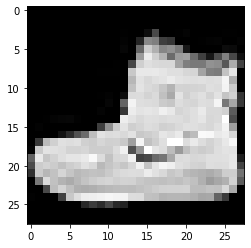

In [16]:
plt.imshow(train_X[0], cmap="gray")

In [28]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z)*(1.0 - sigmoid(z))

def mse(a, y):
    return .5*sum((a[i] - y[i])**2 for i in range(10))[0]

def initialize_weights(layers = [784, 60, 60, 10]):
    # The following Python lists will contain numpy matrices
    # connected the layers in the neural network 
    W = [[0.0]]
    B = [[0.0]]
    for i in range(1, len(layers)):
        # The scalling factor is something I found in a research paper :)
        w_temp = np.random.randn(layers[i], layers[i-1])*np.sqrt(2/layers[i-1])
        b_temp = np.random.randn(layers[i], 1)*np.sqrt(2/layers[i-1])
    
        W.append(w_temp)
        B.append(b_temp)
    return W, B

In [33]:
W, B = initialize_weights()

def forward_pass(W, B, xi, predict_vector = False):
    Z = [[0.0]]
    A = [xi]
    L = len(W) - 1
    for i in range(1, L + 1):
        z = W[i] @ A[i-1] + B[i]
        Z.append(z)
        
        a = sigmoid(z)
        A.append(a)
        
    if predict_vector == False:
        return Z, A
    else:
        return A[-1]

def predict(W, B, xi):
    _, A = forward_pass(W, B, xi)
    return np.argmax(A[-1])
y_hat = forward_pass(W, B, flat_train_X[0], predict_vector=True)
print(f"Prediction: np.argmax(y_hat) = {np.argmax(y_hat)}")
print(f"Target Label: np.argmax(yi) = {np.argmax(yi)}")
print(f"mse(y_hat, yi) = {mse(y_hat, yi)}")

def MSE(W, B, X, y):
    cost = 0.0
    m = 0
    for xi, yi in zip(X, y):
        a = forward_pass(W, B, xi, predict_vector = True)
        cost += mse(a, yi)
        m+=1
    return cost/m

Prediction: np.argmax(y_hat) = 2
Target Label: np.argmax(yi) = 9
mse(y_hat, yi) = 1.4185930959937363


In [34]:
class DenseNetwork(object):
    def __init__(self, layers = [784, 60, 60, 10]):
        self.layers = layers
        self.W, self.B = initialize_weights(layers = self.layers)

    def train(self, X_train, y_train, alpha = 0.046, epochs = 4):
        # Print the initial mean squared error
        self.errors_ = [MSE(self.W, self.B, X_train, y_train)]
        print(f"Starting Cost = {self.errors_[0]}")

        # Find your sample size
        sample_size = len(X_train)

        # Find the number of non-input layers.
        L = len(self.layers) - 1

        # For each epoch perform stochastic gradient descent. 
        for k in range(epochs):
            # Loop over each (xi, yi) training pair of data.
            for xi, yi in zip(X_train, y_train):
                # Use the forward pass function defined before
                # and find the preactivation and postactivation values.
                Z, A = forward_pass(self.W, self.B, xi)

                # Store the errors in a dictionary for clear interpretation
                # of computation of these values.
                deltas = dict()

                # Compute the output error 
                output_error = (A[L] - yi)*d_sigmoid(Z[L])
                deltas[L] = output_error

                # Loop from L-1 to 1. Recall the right entry of the range function 
                # is non-inclusive. 
                for i in range(L-1, 0, -1):
                    # Compute the node errors at each hidden layer
                    deltas[i] = (self.W[i+1].T @ deltas[i+1])*d_sigmoid(Z[i])

                # Loop over each hidden layer and the output layer to perform gradient 
                # descent. 
                for i in range(1, L+1):
                    self.W[i] -= alpha*deltas[i] @ A[i-1].T
                    self.B[i] -= alpha*deltas[i]

            # Show the user the cost over all training examples
            self.errors_.append(MSE(self.W, self.B, X_train, y_train))   
            print(f"{k + 1}-Epoch Cost = {self.errors_[-1]}")
    

    def predict(self, xi):
        depth = len(self.layers)
        _, A = forward_pass(self.W, self.B, xi)
        return np.argmax(A[-1])

In [36]:
net = DenseNetwork(layers = [784, 120, 145, 120, 10])

# Check the mean squared error before training 
print(f"MSE(net.W, net.B, flat_train_X, onehot_train_y) = {MSE(net.W, net.B, flat_train_X, onehot_train_y)} \n")
net.train(flat_train_X, onehot_train_y)

MSE(net.W, net.B, flat_train_X, onehot_train_y) = 1.7339315559156503 

Starting Cost = 1.7339315559156503
1-Epoch Cost = 0.1318631714707763
2-Epoch Cost = 0.11271589849945428
3-Epoch Cost = 0.10293958258969733
4-Epoch Cost = 0.0954940561054876


In [47]:
y_pred = []
actual_y = []
for i in range(len(flat_test_X)):
    prediction = net.predict(flat_test_X[i])
    y_pred.append(prediction)
    actual_y.append(np.argmax(onehot_test_y[i]))

C:\Users\Amir Ma\AppData\Local\Temp\ipykernel_14188\3429594674.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


In [48]:
accuracy_score(y_pred,actual_y)

0.8232

In [50]:
model_report = classification_report(y_pred,actual_y)
print("\nClassification Report")
print(model_report)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       949
           1       0.97      0.93      0.95      1044
           2       0.70      0.76      0.73       915
           3       0.83      0.82      0.82      1008
           4       0.86      0.64      0.73      1351
           5       0.75      0.99      0.85       758
           6       0.47      0.73      0.57       652
           7       0.93      0.87      0.90      1066
           8       0.97      0.88      0.93      1097
           9       0.97      0.84      0.90      1160

    accuracy                           0.82     10000
   macro avg       0.82      0.83      0.82     10000
weighted avg       0.84      0.82      0.83     10000

